In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [24]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from copy import deepcopy

# Define label mappings
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}


In [25]:
# Create a DataFrame with image paths and labels
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):  # Iterate over the label directories (dry, normal, oily)
        label = os.path.join(base, i)
        for j in os.listdir(label):  # Iterate over images in the label directory
            img = os.path.join(label, j)
            dd["images"].append(img)
            dd["labels"].append(label_index[i])
    return pd.DataFrame(dd)


In [26]:
# Create DataFrames for train, validation, and test sets
train_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train")
val_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid")
test_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test")



In [27]:
# Combine all data, then split into train/validation/test sets
train_df, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val_df, test_df = train_test_split(testing, random_state=42, test_size=0.5)

In [28]:
# Dataset class for loading images and labels
class CloudDS(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img_path, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)  # Apply transformations directly to PIL image
        
        return img, label



In [29]:
# Define augmentation transformations for the training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),   # Randomly crop and resize to 224x224
    transforms.RandomRotation(30),       # Randomly rotate images by ±30 degrees
    transforms.RandomHorizontalFlip(),   # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),     # Randomly flip images vertically
    transforms.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2
    ),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),               # Convert image to PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],      # Normalize the tensor
        std=[0.229, 0.224, 0.225]
    )
])


In [30]:
# Define transformations for validation and test sets
val_test_transforms = transforms.Compose([
    transforms.Resize(256),              # Resize the shorter side to 256 pixels
    transforms.CenterCrop(224),          # Crop the center 224x224 pixels
    transforms.ToTensor(),               # Convert image to PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],      # Normalize the tensor
        std=[0.229, 0.224, 0.225]
    )
])



In [31]:
# Create Dataset and DataLoader instances
train_dataset = CloudDS(train_df, transform=train_transforms)
val_dataset = CloudDS(val_df, transform=val_test_transforms)
test_dataset = CloudDS(test_df, transform=val_test_transforms)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [32]:
# Load pre-trained ResNet50 and adjust the final layer
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 3)  # Output for 3 classes: dry, normal, oily

In [33]:
# Check if CUDA is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = deepcopy(resnet).to(device)

In [34]:
# Define loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [35]:
# Training and evaluation loop
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1,51):  # EPOCHS = 20
    model.train()  # Set model to training mode
    
    diff = 0
    total = 0
    acc = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
            
        out = model(data)
        
        # Check if the shapes are correct
        #print(f"Output shape: {out.shape}, Target shape: {target.shape}")

        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        
        loss.backward()
        optimizer.step()
        
    train_loss.append(diff / total)
    train_acc.append(acc / total)
    
    # Validation step
    model.eval()  # Set model to evaluation mode
    
    diff = 0
    total = 0
    acc = 0
    
    with torch.no_grad():
        for data, target in val_dl:
            data, target = data.to(device), target.to(device)
                
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
            
    val_loss.append(diff / total)
    val_acc.append(acc / total)
    
    # Save the best model
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    # Step the learning rate scheduler
    scheduler.step()
    
    print(f"Epoch {epoch}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

Epoch 1, Train Loss: 0.0332, Train Acc: 0.4333, Val Loss: 0.0345, Val Acc: 0.3804
Epoch 2, Train Loss: 0.0316, Train Acc: 0.4914, Val Loss: 0.0337, Val Acc: 0.4819
Epoch 3, Train Loss: 0.0308, Train Acc: 0.5054, Val Loss: 0.0344, Val Acc: 0.5181
Epoch 4, Train Loss: 0.0293, Train Acc: 0.5454, Val Loss: 0.0286, Val Acc: 0.5833
Epoch 5, Train Loss: 0.0279, Train Acc: 0.5776, Val Loss: 0.0313, Val Acc: 0.5725
Epoch 6, Train Loss: 0.0261, Train Acc: 0.6084, Val Loss: 0.0309, Val Acc: 0.5870
Epoch 7, Train Loss: 0.0247, Train Acc: 0.6397, Val Loss: 0.0271, Val Acc: 0.6159
Epoch 8, Train Loss: 0.0231, Train Acc: 0.6788, Val Loss: 0.0277, Val Acc: 0.6232
Epoch 9, Train Loss: 0.0218, Train Acc: 0.6874, Val Loss: 0.0235, Val Acc: 0.7138
Epoch 10, Train Loss: 0.0207, Train Acc: 0.7114, Val Loss: 0.0188, Val Acc: 0.7717
Epoch 11, Train Loss: 0.0189, Train Acc: 0.7505, Val Loss: 0.0166, Val Acc: 0.7935
Epoch 12, Train Loss: 0.0181, Train Acc: 0.7564, Val Loss: 0.0231, Val Acc: 0.7174
Epoch 13, Tra

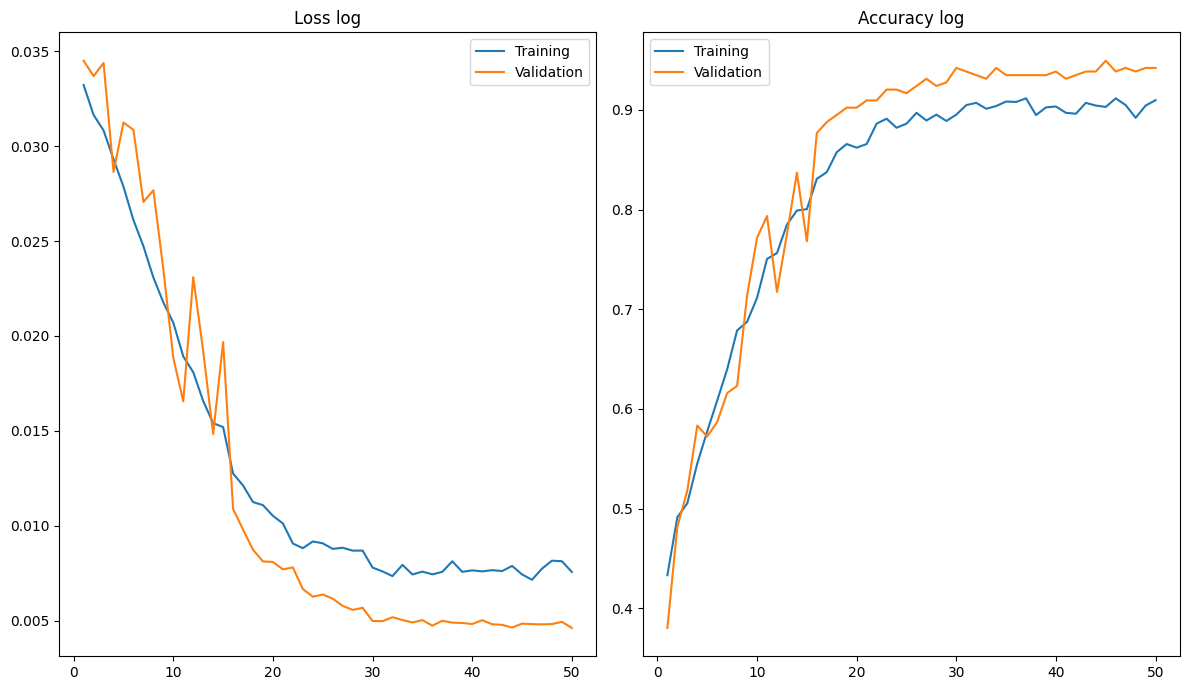

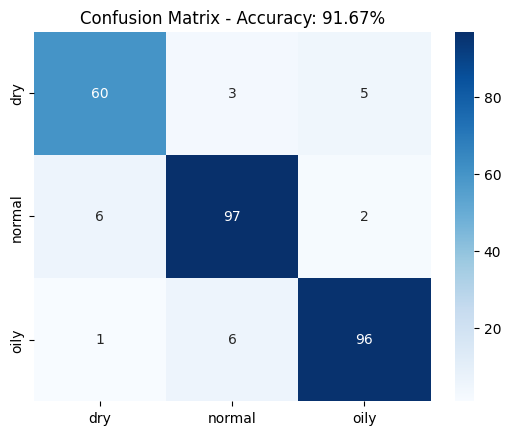

              precision    recall  f1-score   support

         dry       0.90      0.88      0.89        68
      normal       0.92      0.92      0.92       105
        oily       0.93      0.93      0.93       103

    accuracy                           0.92       276
   macro avg       0.91      0.91      0.91       276
weighted avg       0.92      0.92      0.92       276



In [36]:
import matplotlib.pyplot as plt
EPOCHS = 50

# Plotting the Loss and Accuracy logs
epochs = list(range(1, EPOCHS + 1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

# Prediction function for test images
def predict(x):
    img = Image.open(x).convert("RGB")
    img = val_test_transforms(img).unsqueeze(0)  # Apply the validation/test transformations
    best_model.eval()
    with torch.no_grad():
        img = img.to(device)
        out = best_model(img)
        return out.argmax(1).item()

# Evaluate the model on the test set
pred = []
truth = []

for i in range(test_df.shape[0]):
    pred.append(predict(test_df.iloc[i, 0]))  # Predict the label for each test image
    truth.append(test_df.iloc[i, 1])  # Get the true label

# Calculate accuracy and display classification report
score = accuracy_score(truth, pred)
report = classification_report(truth, pred, target_names=["dry", "normal", "oily"])
cm = confusion_matrix(truth, pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["dry", "normal", "oily"], yticklabels=["dry", "normal", "oily"])
plt.title("Confusion Matrix - Accuracy: {}%".format(round(score * 100, 2)))
plt.show()

# Print the classification report
print(report)

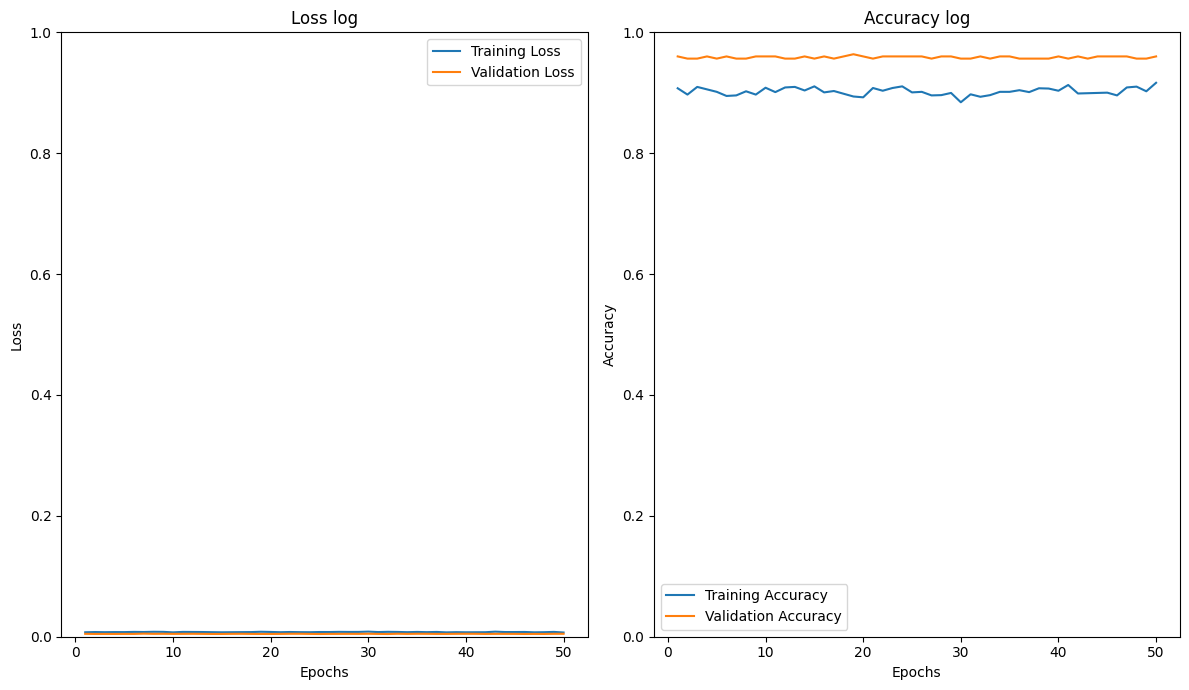

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample data for demonstration (replace these with your actual logs)
EPOCHS = 50
epochs = list(range(1, EPOCHS + 1))
# train_loss = np.random.uniform(0.1, 0.5, EPOCHS)  # Random data for training loss
# val_loss = np.random.uniform(0.2, 0.5, EPOCHS)  # Random data for validation loss
# train_acc = np.random.uniform(0.5, 1.0, EPOCHS)  # Random data for training accuracy
# val_acc = np.random.uniform(0.5, 0.9, EPOCHS)  # Random data for validation accuracy

# Plotting the Loss and Accuracy logs with y-axis from 0 to 1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))

# Plotting Loss
axes[0].plot(epochs, train_loss, label="Training Loss")
axes[0].plot(epochs, val_loss, label="Validation Loss")
axes[0].set_ylim([0, 1])  # Y-axis from 0 to 1
axes[0].legend()
axes[0].set_title("Loss log")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

# Plotting Accuracy
axes[1].plot(epochs, train_acc, label="Training Accuracy")
axes[1].plot(epochs, val_acc, label="Validation Accuracy")
axes[1].set_ylim([0, 1])  # Y-axis from 0 to 1
axes[1].legend()
axes[1].set_title("Accuracy log")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [21]:
# Prediction function for test images
def predict(x):
    img = Image.open(x).convert("RGB")
    img = val_test_transforms(img).unsqueeze(0)  # Apply the validation/test transformations
    best_model.eval()
    with torch.no_grad():
        img = img.to(device)
        out = best_model(img)
        return out.argmax(1).item()
​
# Evaluate the model on the test set
pred = []
truth = []
​
for i in range(test_df.shape[0]):
    pred.append(predict(test_df.iloc[i, 0]))  # Predict the label for each test image
    truth.append(test_df.iloc[i, 1])  # Get the true label
​
# Calculate accuracy and display classification report
score = accuracy_score(truth, pred)
report = classification_report(truth, pred, target_names=["dry", "normal", "oily"])
cm = confusion_matrix(truth, pred)
​
# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["dry", "normal", "oily"], yticklabels=["dry", "normal", "oily"])
plt.title("Confusion Matrix - Accuracy: {}%".format(round(score * 100, 2)))
plt.show()
​
# Print the classification report
print(report)

SyntaxError: invalid non-printable character U+200B (3476831100.py, line 10)

In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from copy import deepcopy

# Define label mappings
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

# Create a DataFrame with image paths and labels
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):  # Iterate over the label directories (dry, normal, oily)
        label = os.path.join(base, i)
        for j in os.listdir(label):  # Iterate over images in the label directory
            img = os.path.join(label, j)
            dd["images"].append(img)
            dd["labels"].append(label_index[i])
    return pd.DataFrame(dd)

# Create DataFrames for train, validation, and test sets
train_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train")
val_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid")
test_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test")

# Combine all data, then split into train/validation/test sets
train_df, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val_df, test_df = train_test_split(testing, random_state=42, test_size=0.5)

# Dataset class for loading images and labels
class CloudDS(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img_path, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)  # Apply transformations directly to PIL image
        
        return img, label

# Define augmentation transformations for the training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),   # Randomly crop and resize to 224x224
    transforms.RandomRotation(30),       # Randomly rotate images by ±30 degrees
    transforms.RandomHorizontalFlip(),   # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),     # Randomly flip images vertically
    transforms.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2
    ),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),               # Convert image to PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],      # Normalize the tensor
        std=[0.229, 0.224, 0.225]
    )
])

# Define transformations for validation and test sets
val_test_transforms = transforms.Compose([
    transforms.Resize(256),              # Resize the shorter side to 256 pixels
    transforms.CenterCrop(224),          # Crop the center 224x224 pixels
    transforms.ToTensor(),               # Convert image to PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],      # Normalize the tensor
        std=[0.229, 0.224, 0.225]
    )
])

# Create Dataset and DataLoader instances
train_dataset = CloudDS(train_df, transform=train_transforms)
val_dataset = CloudDS(val_df, transform=val_test_transforms)
test_dataset = CloudDS(test_df, transform=val_test_transforms)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet50 and adjust the final layer
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add Dropout to prevent overfitting
    nn.Linear(resnet.fc.in_features, 3)  # Output for 3 classes: dry, normal, oily
)

# Check if CUDA is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = deepcopy(resnet).to(device)

# Add class weights if the dataset is imbalanced
class_weights = torch.tensor([1.0, 1.2, 0.8]).to(device)  # Modify these weights based on class distribution
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer and learning rate scheduler
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)  # Reduce learning rate and add weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early stopping criteria
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"Early stopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# Training and evaluation loop
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    model.train()  # Set model to training mode
    
    diff = 0
    total = 0
    acc = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
            
        out = model(data)

        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        
        loss.backward()
        optimizer.step()
        
    train_loss.append(diff / total)
    train_acc.append(acc / total)
    
    # Validation step
    model.eval()  # Set model to evaluation mode
    
    diff = 0
    total = 0
    acc = 0
    
    with torch.no_grad():
        for data, target in val_dl:
            data, target = data.to(device), target.to(device)
                
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
            
    val_loss.append(diff / total)
    val_acc.append(acc / total)
    
    # Save the best model
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    # Step the learning rate scheduler
    scheduler.step(val_loss[-1])
    
    # Early stopping
    early_stopping(val_loss[-1])
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break
        
print(f"Epoch {epoch}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

Early stopping counter: 1/5
Early stopping counter: 1/5
Early stopping counter: 1/5
Early stopping counter: 1/5
Early stopping counter: 1/5
Early stopping counter: 1/5
Early stopping counter: 1/5
Early stopping counter: 1/5
Early stopping counter: 1/5
Early stopping counter: 1/5
Early stopping counter: 2/5
Epoch 50, Train Loss: 0.0147, Train Acc: 0.7945, Val Loss: 0.0112, Val Acc: 0.8768


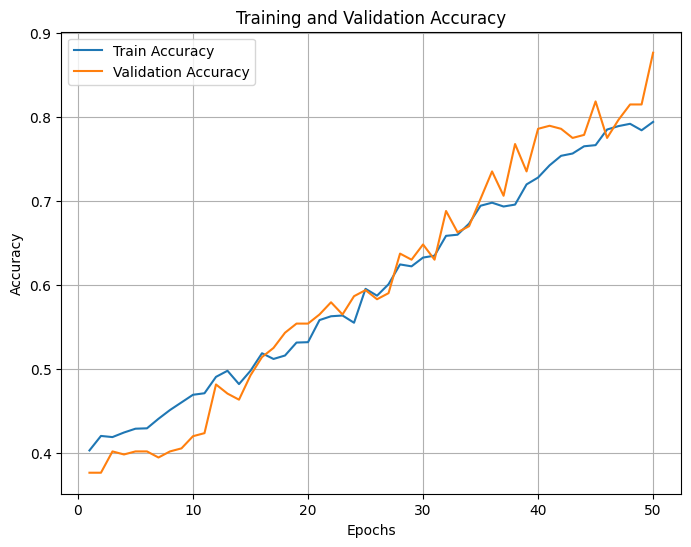

In [6]:
import matplotlib.pyplot as plt

# Assuming train_acc and val_acc contain accuracy values for each epoch
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.grid(True)
plt.show()


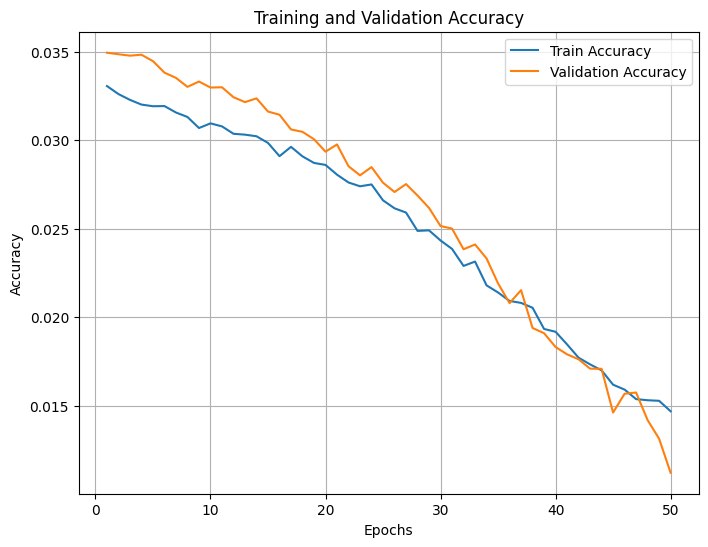

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Train Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.grid(True)
plt.show()

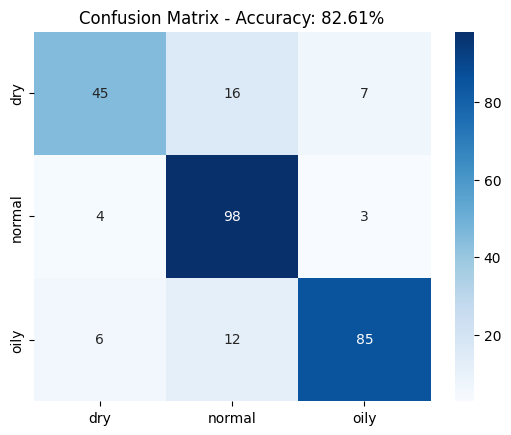

              precision    recall  f1-score   support

         dry       0.82      0.66      0.73        68
      normal       0.78      0.93      0.85       105
        oily       0.89      0.83      0.86       103

    accuracy                           0.83       276
   macro avg       0.83      0.81      0.81       276
weighted avg       0.83      0.83      0.82       276



In [9]:
# Prediction function for test images
def predict(x):
    img = Image.open(x).convert("RGB")
    img = val_test_transforms(img).unsqueeze(0)  # Apply the validation/test transformations
    best_model.eval()
    with torch.no_grad():
        img = img.to(device)
        out = best_model(img)
        return out.argmax(1).item()

# Evaluate the model on the test set
pred = []
truth = []

for i in range(test_df.shape[0]):
    pred.append(predict(test_df.iloc[i, 0]))  # Predict the label for each test image
    truth.append(test_df.iloc[i, 1])  # Get the true label

# Calculate accuracy and display classification report
score = accuracy_score(truth, pred)
report = classification_report(truth, pred, target_names=["dry", "normal", "oily"])
cm = confusion_matrix(truth, pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["dry", "normal", "oily"], yticklabels=["dry", "normal", "oily"])
plt.title("Confusion Matrix - Accuracy: {}%".format(round(score * 100, 2)))
plt.show()

# Print the classification report
print(report)